# Description
This program reads FLIR thermal images and saves them as floating-point TIF files, which can be read much faster than the original FLIR *_R.jpeg files.

## Import libraries

In [1]:
import numpy as np
from tifffile import imsave, imread
import glob
from timeit import default_timer as timer
import os.path

import subprocess
import json
import io
from PIL import Image
from math import sqrt, exp, log
from matplotlib import cm
from matplotlib import pyplot as plt

## Settings

In [11]:
project_path = '.' # Current directory

input_dir  = project_path + "/example_input/"
output_dir = project_path + "/example_output/"

## Functions

In [12]:
%%time
def raw_to_temp(filename, E, OD, RTemp, ATemp, RH, IRWTemp, IRT):
    exiftool_path = './exiftool-exe/exiftool.exe'

    """
    extracts the thermal image as 2D numpy array with temperatures in oC
    """

    # read image metadata needed for conversion of the raw sensor values
    # E=1,SD=1,RTemp=20,ATemp=RTemp,IRWTemp=RTemp,IRT=1,RH=50,PR1=21106.77,PB=1501,PF=1,PO=-7340,PR2=0.012545258
    meta_json = subprocess.check_output(
        [exiftool_path, filename, '-Emissivity', '-SubjectDistance', '-AtmosphericTemperature',
         '-ReflectedApparentTemperature', '-IRWindowTemperature', '-IRWindowTransmission', '-RelativeHumidity',
         '-PlanckR1', '-PlanckB', '-PlanckF', '-PlanckO', '-PlanckR2', '-j','-Model'])
    meta = json.loads(meta_json.decode())[0]

    # exifread can't extract the embedded thermal image, use exiftool instead
    thermal_img_bytes = subprocess.check_output([exiftool_path, "-RawThermalImage", "-b", filename])
    thermal_img_stream = io.BytesIO(thermal_img_bytes)

    thermal_img = Image.open(thermal_img_stream)
    thermal_np = np.array(thermal_img)

    PR1=meta['PlanckR1']
    PB=meta['PlanckB']
    PF=meta['PlanckF']
    PO=meta['PlanckO']
    PR2=meta['PlanckR2']

    #thermal_np = raw2tempfunc(thermal_np)
    # constants
    ATA1 = 0.006569 #  attenuation for atmosphere without water vap
    ATA2 = 0.01262 #  attenuation for atmosphere without water vap
    ATB1 = -0.002276 # attenuation for water vapor
    ATB2 = -0.00667 # attenuation for water vapor
    ATX = 1.9 # scaling factor atmosphere damping

    # transmission through window (calibrated)
    emiss_wind = 1 - IRT

    # transmission through the air
    
    h2o = (RH / 100) * exp(1.5587 + 0.06939 * (ATemp) - 0.00027816 * (ATemp) ** 2 + 0.00000068455 * (ATemp) ** 3)
    tau = ATX * exp(-sqrt(OD) * (ATA1 + ATB1 * sqrt(h2o))) + (1 - ATX) * exp(
        -sqrt(OD) * (ATA2 + ATB2 * sqrt(h2o)))
    
    # radiance from the environment
    
    raw_refl = PR1 / (PR2 * (exp(PB / (RTemp + 273.15)) - PF)) - PO
    raw_refl_attn = (1 - E) * tau * raw_refl
    raw_atm = PR1 / (PR2 * (exp(PB / (ATemp + 273.15)) - PF)) - PO
    raw_atm_attn = (1 - tau) * raw_atm
    raw_wind = PR1 / (PR2 * (exp(PB / (IRWTemp + 273.15)) - PF)) - PO
    raw_wind_attn = emiss_wind / IRT * raw_wind
    raw_obj = (thermal_np / IRT - raw_refl_attn - raw_atm_attn - raw_wind_attn)/ E / tau
    temp_celcius = PB / np.log(PR1 / (PR2 * (raw_obj + PO)) + PF) - 273.15
    
    return temp_celcius

Wall time: 0 ns


## Load images from FLIR, save as tif

In [13]:
debug = False
max_img = 10 # debug, allows to end the loop early
E = 1.0        # Emissivity
OD = 0.0       # Object distance [m]
RTEMP = 30     # Reflected (background) temperature [C] - irrelevant if E = 1 & OD = 0
ATEMP = 35     # Atm. temperature [C]                   - irrelevant if E = 1 & OD = 0
RH = 50        # Relative humidity of the air [%]       - irrelevant if E = 1 & OD = 0
IRWTemp = 25   # External optics temperature [C]        - irrelevant if IRT = 1
IRT = 1.0      # External optics transmissivity

total_files = len(glob.glob(input_dir + "**/*.jpg", recursive=True))
current_file = 1

print('Total number of files: {0:d}'.format(total_files))

# Go through input directory
for filename in glob.iglob(input_dir + '**/*.jpg', recursive=True):
    #  find the relative path to save the outputs in the same structure
    output_file = output_dir + os.path.relpath(filename, input_dir)[:-4] + '.tif'
    os.makedirs(output_file[:-24], exist_ok=True)
    # Check if it exists. If yes, skip
    if(os.path.exists(output_file)):
        print("File exists")
        pass
    else: 
        # Load IR images to np array
        img = raw_to_temp(filename, E, OD, RTEMP, ATEMP, RH, IRWTemp, IRT)
        # Write np array to file
        imsave(output_file, img) # Make sure this array is saved as whatever bit depth is necessary. Check what bit depth the np array has
        pass
    
    # Show progress
    if(current_file % 250 == 0):
        progress = current_file*100/total_files
        print('{0:.2f}'.format(progress) + "%\t" + str(current_file) + "/" + str(total_files) + "\t" + output_file) #filename[-24:])
    current_file += 1
    
    if(current_file >= max_img and debug): # debug, allows to end the loop early
        print("End due to debug")
        break
print("Done...")

Total number of files: 1
Done...


## Example: Read .tif and plot

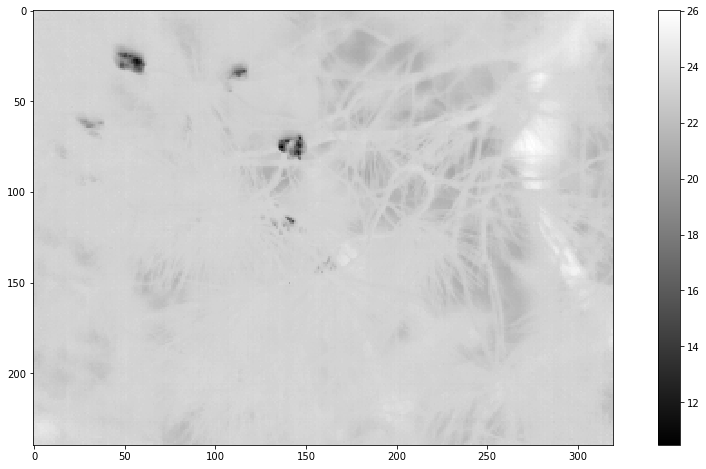

In [14]:
# To read the tif later
data = imread(output_dir + 'file-20171218-161159.tif')

plt.figure(figsize=(16, 8))
plt.imshow(data, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

## Example: Read all .tif files

In [30]:
# Reading .tif files is really fast :-)

import glob
total_files = len(glob.glob(output_dir + "**/*.tif", recursive=True))
current_file = 0

print('Total number of files: {0:d}'.format(total_files))
max_img = 2 # debug, allows to end the loop early

# Go through input directory
for filename in glob.iglob(output_dir + '**/*.tif', recursive=True):
    # Show progress
    progress = current_file*100/total_files
    #print('{0:.2f}'.format(progress) + "%\t" + filename[-24:]) # This output is just too much
    current_file += 1
    # Load
    data = imread(filename)

Total number of files: 0


## Tests: Diagnostics comparing FLIR ResearchIR and this script

If the file is saved as .csv from FLIR's ResearchIR software, it can be compared to this current script. The result should be noise with very low values if the script works well. We conclusively confirm that it is the case

788.844719539772


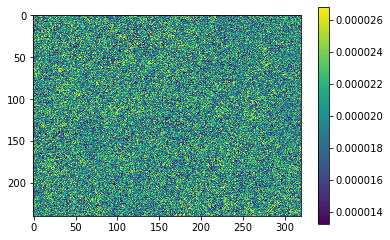

In [24]:
raw_fn            = './researchIR/file-20171218-161159.jpg'
researchIR_csv_fn = './researchIR/file-20171218-161159.csv'

# Experiment with the settings to check that the difference is really just noise
E = 0.8; OD = 50; RTEMP = 30; ATEMP = 35; RH = 60; IRWTemp = 25; IRT = 0.96

T_image = raw_to_temp(raw_fn, E, OD, RTEMP, ATEMP, RH, IRWTemp, IRT)

flir_org_image = np.genfromtxt(researchIR_csv_fn, delimiter=',')

plt.imshow(flir_org_image-T_image)
plt.colorbar()